<a href="https://colab.research.google.com/github/mkxdxdxd/CSED499I/blob/main/exp3_final_hn_cn_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show javalang
!pip install javalang
import os

#1. Settings

### 1) import required

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/dataset.pkl')

In [ ]:
print(data.columns)

Index(['SubjectID', 'AssignmentID', 'ProblemID', 'CodeStateID', 'Score_x',
       'Code', 'Code-ast', 'code-astnn', 'code-embedding', 'Score_y',
       'embedding', 'astnn', 'prompt', 'prompt-embedding', 'input'],
      dtype='object')


### 2) Set hyperparameters

In [ ]:
learning_rate = 1e-2
batch_size = 35
epochs = 1500

In [ ]:
input_size=768
hidden_size=100
num_layers=3
output_size=200
bidirectional=False
batch_first=True

### 3) Data preprocessing

In [ ]:
data_stu_code = data[['SubjectID', 'prompt-embedding', 'embedding']]
# print(data_stu_code)

In [ ]:
grouped = data_stu_code.groupby('SubjectID')

students_data ={}
for subject_id, group in grouped:
    #print(group['prompt-embedding'])
    embeddings = group['prompt-embedding'].tolist()  # Converting string representations of lists back to lists
    labels = group['embedding'].tolist()

    embeddings = np.array(embeddings, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    students_data[subject_id] = (embeddings, labels)

# 2. Training

### 1) model

In [ ]:
#build LSTM network
#experiment 3-2 code: h0 set to a leanable parameter + passing final hidden state
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
     super().__init__()
     self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
     self.num_layers = num_layers
     self.num_directions = 2 if bidirectional else 1
     self.lstm = nn.LSTM(input_size=self.input_size, hidden_size = self.hidden_size, num_layers=self.num_layers, bidirectional=bidirectional, batch_first=True)
     self.linear = nn.Linear(self.hidden_size * self.num_directions, output_size)
     self.h0 = nn.Parameter(torch.zeros(self.num_layers,1,self.hidden_size))
     self.c0 = nn.Parameter(torch.zeros(self.num_layers,1,self.hidden_size))
  def forward(self, x, h0=None, c0=None):
    if h0 is None or c0 is None:
      h0 = self.h0
      c0 = self.h0
    x, (hn, cn) = self.lstm(x,(h0,c0))
    output = self.linear(x)
    return output, (hn, cn)

#experiment 3-1 code: h0 set to 0 + passing final hidden state

# class LSTMModel(nn.Module):
#   def __init__(self, input_size, hidden_size, num_layers, output_size):
#      super().__init__()
#      self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
#      self.num_layers = num_layers
#      self.num_directions = 2 if bidirectional else 1
#      self.lstm = nn.LSTM(input_size=self.input_size, hidden_size = self.hidden_size, num_layers=self.num_layers, bidirectional=bidirectional, batch_first=True)
#      self.linear = nn.Linear(self.hidden_size * self.num_directions, output_size)

#   def forward(self, x, h0=None, c0=None):
#     if h0 is None or c0 is None:
#       batch_size = x.size(0)  # Get batch size from input tensor
#       h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
#       c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
#     x, (hn, cn) = self.lstm(x,(h0,c0))
#     output = self.linear(x)
#     return output, (hn, cn)

### 2) Training pipeline

In [ ]:
val_loss_history = {}
train_loss_history = {}
test_loss_history = {}

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # prediction and loss calculation
        pred, (hn, cn) = model(X)
        loss = loss_fn(pred, y)


        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if student_id not in train_loss_history:
              train_loss_history[student_id] = []
            train_loss_history[student_id].append(loss)
            print(f"Train loss: {loss:>8f}")
    last_hidden_state_test = (hn, cn)
    return last_hidden_state_test

def val_loop(dataloader, model, loss_fn, last_hidden_state_test):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred, (hn, cn) = model(X, h0=last_hidden_state_test[0], c0=last_hidden_state_test[1])
            val_loss += loss_fn(pred, y).item() #calculate val loss

    val_loss /= num_batches
    if student_id not in val_loss_history:
      val_loss_history[student_id] = []
    val_loss_history[student_id].append(val_loss)
    print(f"val loss: {val_loss:>8f} ")
    last_hidden_state_val = (hn, cn)
    return last_hidden_state_val

def test_loop(dataloader, model, loss_fn, last_hidden_state_val):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in dataloader:
          pred, (hn, cn) = model(X, h0=last_hidden_state_val[0], c0=last_hidden_state_val[1])
          test_loss += loss_fn(pred, y).item() #calculate val loss

  test_loss /= num_batches
  if student_id not in test_loss_history:
      test_loss_history[student_id] = []
  test_loss_history[student_id].append(test_loss)
  print(f"test loss: {test_loss:>8f} \n")

### 3) Training loop

In [ ]:
model = {}
test_loss_early_stopping = {}

for student_id, _ in students_data.items():
  one_student = students_data[student_id]
  X = torch.tensor(one_student[0])
  y = torch.tensor(one_student[1])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #training:test = 8:2
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2, shuffle=False) #training:valid = 8:2 again

  X_train = X_train.unsqueeze(0)  # Add a batch dimension
  X_test = X_test.unsqueeze(0)
  X_val = X_val.unsqueeze(0)

  y_train = y_train.unsqueeze(0)
  y_test = y_test.unsqueeze(0)
  y_val = y_val.unsqueeze(0)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)
  valid_dataset = TensorDataset(X_val, y_val)

  dataloaders = {}
  dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  dataloaders['valid'] = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model[student_id] = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
  loss_func = nn.MSELoss()
  optimizer = torch.optim.Adam(model[student_id].parameters(), lr=learning_rate)

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print(f"Student_id: {student_id}")
    last_hidden_state_test = train_loop(dataloaders['train'], model[student_id], loss_func, optimizer)
    last_hidden_state_val = val_loop(dataloaders['valid'], model[student_id], loss_func, last_hidden_state_test)
    test_loop(dataloaders['test'], model[student_id], loss_func, last_hidden_state_val)
  print("Done!")

  index_min = min(range(len(val_loss_history[student_id])), key=val_loss_history[student_id].__getitem__)
  test_loss_early_stopping[student_id] = test_loss_history[student_id][index_min]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 787
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004728
val loss: 0.111952 
test loss: 0.130049 

Epoch 788
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004641
val loss: 0.113144 
test loss: 0.131353 

Epoch 789
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004462
val loss: 0.112737 
test loss: 0.130884 

Epoch 790
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004352
val loss: 0.111231 
test loss: 0.129982 

Epoch 791
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004333
val loss: 0.111830 
test loss: 0.129632 

Epoch 792
-------------------------------
Student_id: ffb72475a81de0e95b910ffad039f5c2
Train loss: 0.004129
val loss: 0.111814 
test loss: 0.129240 

Epoch 793
-------------------------------
Student_id: ffb72475a

### 4) learning curve

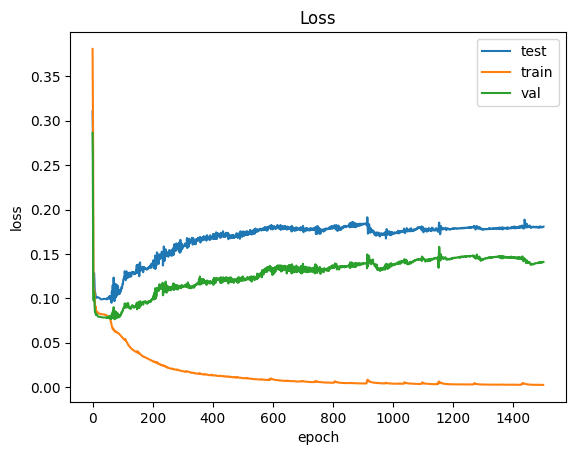

Minimum for validation set
epoch:  74 value:  0.07642117887735367
test loss:  0.09672947227954865


In [ ]:
#Let's draw a learning curve like below.
student_id = "04c32d4d95425f73b3a1d6502aed4d48"
plt.plot(test_loss_history[student_id], label='test')
plt.plot(train_loss_history[student_id], label='train')
plt.plot(val_loss_history[student_id], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend()
plt.show()

index_min = min(range(len(val_loss_history)), key=val_loss_history.__getitem__)
print("Minimum for validation set")
print("epoch: ", index_min+1, "value: ", min(val_loss_history))
print("test loss: ", test_loss_history[index_min]) #test loss for such epoch

### 5) Download data

In [ ]:
lstm_test_loss = pd.DataFrame(list(test_loss_early_stopping.items()), columns=['SubjectID', 'Test loss'])

from google.colab import files
lstm_test_loss.to_csv('lstm_test_loss_sequential_learnable.csv')

files.download('lstm_test_loss_sequential_learnable.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>